Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Classes in this batch: tensor([87,  0, 52, 58, 44, 91, 68, 97, 51, 15])


Before first epoch
  validation loss:		29.787861
  top 1 accuracy:		0.10 %
  top 5 accuracy:		0.90 %
Batch of classes number 1 arrives ...
0.2545773684978485
Batch of classes 1 out of 10 batches
Epoch 1 of 70 took 6.627s
  training loss:		0.065153
  validation loss:		0.026547
  top 1 accuracy:		41.50 %
  top 5 accuracy:		85.60 %
0.024929381906986237
Batch of classes 1 out of 10 batches
Epoch 2 of 70 took 5.207s
  training loss:		0.022517
  validation loss:		0.022188
  top 1 accuracy:		52.20 %
  top 5 accuracy:		93.50 %
0.025051536038517952
Batch of classes 1 out of 10 batches
Epoch 3 of 70 took 6.359s
  training loss:		0.020457
  validation loss:		0.020533
  top 1 accuracy:		55.80 %
  top 5 accuracy:		94.70 %
0.018849622458219528
Batch of classes 1 out of 10 batches
Epoch 4 of 70 took 5.178s
  trainin

Final results on cumul of classes:
  top 1 accuracy iCaRL          :		88.50 %
  top 1 accuracy Hybrid 1       :		88.20 %
  top 1 accuracy NCM            :		88.40 %


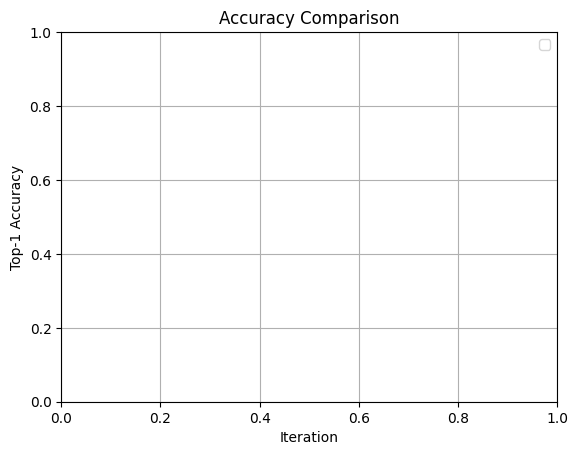

Classes in this batch: tensor([94, 92, 10, 72, 49, 78, 61, 14,  8, 86])


Before first epoch
  validation loss:		0.143128
  top 1 accuracy:		0.00 %
  top 5 accuracy:		0.00 %
Batch of classes number 2 arrives ...
0.10054506361484528
Batch of classes 2 out of 10 batches
Epoch 1 of 70 took 8.287s
  training loss:		0.042236
  validation loss:		0.048693
  top 1 accuracy:		11.30 %
  top 5 accuracy:		76.40 %
0.028051959350705147
Batch of classes 2 out of 10 batches
Epoch 2 of 70 took 6.863s
  training loss:		0.027256
  validation loss:		0.040286
  top 1 accuracy:		22.20 %
  top 5 accuracy:		82.80 %
0.027767594903707504
Batch of classes 2 out of 10 batches
Epoch 3 of 70 took 8.486s
  training loss:		0.025438
  validation loss:		0.039016
  top 1 accuracy:		28.00 %
  top 5 accuracy:		88.30 %
0.023165153339505196
Batch of classes 2 out of 10 batches
Epoch 4 of 70 took 6.874s
  training loss:		0.024199
  validation loss:		0.037017
  top 1 accuracy:		36.60 %
  top 5 accuracy:		90.00 %
0.02541900984

KeyboardInterrupt: ignored

In [8]:
import time
from functools import partial
from typing import Callable, Tuple, List

import numpy as np
import torch
from math import ceil
from torch import Tensor
from torch.nn import BCELoss
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.datasets.cifar import CIFAR100
from cl_dataset_tools import NCProtocol, NCProtocolIterator, TransformationDataset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, ConcatDataset
import torchvision.transforms as transforms

from cl_strategies import icarl_accuracy_measure, icarl_cifar100_augment_data
from models import make_icarl_net
from cl_metrics_tools import get_accuracy
from models.icarl_net import IcarlNet, initialize_icarl_net
from utils import get_dataset_per_pixel_mean, make_theano_training_function, make_theano_validation_function, \
    make_theano_feature_extraction_function, make_theano_inference_function, make_batch_one_hot


def main():
    # This script tries to reprodice results of official iCaRL code
    # https://github.com/srebuffi/iCaRL/blob/master/iCaRL-TheanoLasagne/main_cifar_100_theano.py

    ######### Modifiable Settings ##########
    batch_size = 128            # Batch size
    n          = 5              # Set the depth of the architecture: n = 5 -> 32 layers (See He et al. paper)
    # nb_val     = 0            # Validation samples per class
    nb_cl      = 10             # Classes per group (한 그룹 당 클래스 수)
    nb_protos  = 20             # Number of prototypes per class at the end: total protoset memory/ total number of classes
    epochs     = 70             # Total number of epochs
    lr_old     = 2.             # Initial learning rate
    lr_strat   = [49, 63]       # Epochs where learning rate gets decreased
    lr_factor  = 5.             # Learning rate decrease factor ( 학습률 감소 배율)
    wght_decay = 0.00001        # Weight Decay (가중치 감소)
    nb_runs    = 1              # Number of runs (random ordering of classes at each run)
    torch.manual_seed(1993)     # Fix the random seed
    ########################################

    fixed_class_order = [87,  0, 52, 58, 44, 91, 68, 97, 51, 15,
                         94, 92, 10, 72, 49, 78, 61, 14,  8, 86,
                         84, 96, 18, 24, 32, 45, 88, 11,  4, 67,
                         69, 66, 77, 47, 79, 93, 29, 50, 57, 83,
                         17, 81, 41, 12, 37, 59, 25, 20, 80, 73,
                          1, 28,  6, 46, 62, 82, 53,  9, 31, 75,
                         38, 63, 33, 74, 27, 22, 36,  3, 16, 21,
                         60, 19, 70, 90, 89, 43,  5, 42, 65, 76,
                         40, 30, 23, 85,  2, 95, 56, 48, 71, 64,
                         98, 13, 99,  7, 34, 55, 54, 26, 35, 39]

    # fixed_class_order = None
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Line 31: Load the dataset
    # Asserting nb_val == 0 equals to full cifar100
    # That is, we only declare transformations here
    # Notes: dstack and reshape already done inside CIFAR100 class
    # Mean is calculated on already scaled (by /255) images

    transform = transforms.Compose([
        transforms.ToTensor(),  # ToTensor scales from [0, 255] to [0, 1.0]
    ])

    per_pixel_mean = get_dataset_per_pixel_mean(CIFAR100('./data/cifar100', train=True, download=True,
                                                         transform=transform))

    # https://github.com/srebuffi/iCaRL/blob/90ac1be39c9e055d9dd2fa1b679c0cfb8cf7335a/iCaRL-TheanoLasagne/utils_cifar100.py#L146
    transform = transforms.Compose([
        transforms.ToTensor(),
        lambda img_pattern: img_pattern - per_pixel_mean, #(이미지를 텐서로 변환 후, 픽셀별 평균을 뺀다),
        icarl_cifar100_augment_data#(데이터 증강을 수행)),
    ])

    # Must invert previous ToTensor(), otherwise RandomCrop and RandomHorizontalFlip won't work
    transform_prototypes = transforms.Compose([
        icarl_cifar100_augment_data,
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        lambda img_pattern: img_pattern - per_pixel_mean,  # Subtract per-pixel mean
    ])

    # Line 43: Initialization
    dictionary_size = 500
    top1_acc_list_cumul = torch.zeros(100//nb_cl, 3, nb_runs)
    top1_acc_list_ori = torch.zeros(100//nb_cl, 3, nb_runs)

    # Line 48: # Launch the different runs
    # Skipped as this script will only manage singe runs

    # Lines 51, 52, 54 already managed in NCProtocol

    protocol = NCProtocol(CIFAR100('./data/cifar100', train=True, download=True, transform=transform),
                          CIFAR100('./data/cifar100', train=False, download=True, transform=transform_test),
                          n_tasks=100//nb_cl, shuffle=True, seed=None, fixed_class_order=fixed_class_order)

    model: IcarlNet = make_icarl_net(num_classes=100)
    model.apply(initialize_icarl_net)

    model = model.to(device)

    criterion = BCELoss()  # Line 66-67 이진교차엔트로피 함수 생성

    # Line 74, 75
    # Note: sh_lr is a theano "shared"
    sh_lr = lr_old

    # noinspection PyTypeChecker, 검증 함수 정의
    val_fn: Callable[[Tensor, Tensor],
                     Tuple[Tensor, Tensor, Tensor]] = partial(make_theano_validation_function, model,
                                                              BCELoss(), 'feature_extractor',
                                                              device=device)

    # noinspection PyTypeChecker
    function_map: Callable[[Tensor], Tensor] = partial(make_theano_feature_extraction_function, model,
                                                       'feature_extractor', device=device, batch_size=batch_size)

    # Lines 90-97: Initialization of the variables for this run

    x_protoset_cumuls: List[Tensor] = []
    y_protoset_cumuls: List[Tensor] = []
    alpha_dr_herding = torch.zeros((100 // nb_cl, dictionary_size, nb_cl), dtype=torch.float)

    # Lines 101-103: already managed by NCProtocol/NCProtocolIterator

    train_dataset: Dataset
    task_info: NCProtocolIterator

    func_pred: Callable[[Tensor], Tensor] #예측하는 변수 초기화
    # func_pred_feat: Callable[[Tensor], Tensor] # Unused

    for task_idx, (train_dataset, task_info) in enumerate(protocol): # protocol을 순회하면서 반복문을 실행하면서 동시에 각 반복 요소에 train, test idx를 저장하는 것
        print('Classes in this batch:', task_info.classes_in_this_task) # 현재 테스트에 포함된 클래스를 출력

        # Lines 107, 108: Save data results at each increment
        # accuracy 리스트를 파일에 저장
        torch.save(top1_acc_list_cumul, 'top1_acc_list_cumul_icarl_cl' + str(nb_cl))
        torch.save(top1_acc_list_ori, 'top1_acc_list_ori_icarl_cl' + str(nb_cl))

        # Note: lines 111-125 already managed in NCProtocol/NCProtocolIterator

        # Lines 128-135: Add the stored exemplars to the training data
        # Note: X_valid_ori and Y_valid_ori already managed in NCProtocol/NCProtocolIterator
        if task_idx != 0:
          # 첫 번째 task가 아닌 경우, 이전 task의 프로토셋을 현재 학습 데이터셋에 추가
            protoset = TransformationDataset(TensorDataset(torch.cat(x_protoset_cumuls), torch.cat(y_protoset_cumuls)),
                                             transform=transform_prototypes, target_transform=None)
            train_dataset = ConcatDataset((train_dataset, protoset))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

        # Line 137: # Launch the training loop
        # From lines: 69, 70, 76, 77
        # Note optimizer == train_fn
        # weight_decay == l2_penalty
        optimizer = torch.optim.SGD(model.parameters(), lr=sh_lr, weight_decay=wght_decay, momentum=0.9)
        train_fn = partial(make_theano_training_function, model, criterion, optimizer, device=device)
        # 함수를 부분적으로 적용하여 학습 함수 train_fc을 생성합니다. 이 함수는 주어진 모델, 손실 함수, 최적화기, 디바이스를 사용하여 학습을 수행합니다.
        scheduler = MultiStepLR(optimizer, lr_strat, gamma=1.0/lr_factor)
        # 다단계 학습률 스케쥴러인 MultiStepLR을 생성합니다. 이 스케쥴러는 주어진 에폭에서 학습률을 감소시키는데 사용합니다. lr_strat 에서 지정한 에폭에서 학습률을 gamma 값으로 나누어 줄입니다.

        print("\n")

        # Added (not found in original code): validation accuracy before first epoch
        acc_result, val_err, _, _ = get_accuracy(model, task_info.get_current_test_set(), device=device,
                                                 required_top_k=[1, 5], return_detailed_outputs=False,
                                                 criterion=BCELoss(), make_one_hot=True, n_classes=100,
                                                 batch_size=batch_size, shuffle=False, num_workers=8)
        print("Before first epoch")
        print("  validation loss:\t\t{:.6f}".format(val_err))  # Note: already averaged
        print("  top 1 accuracy:\t\t{:.2f} %".format(acc_result[0].item() * 100))
        print("  top 5 accuracy:\t\t{:.2f} %".format(acc_result[1].item() * 100))
        # End of added code

        print('Batch of classes number {0} arrives ...'.format(task_idx + 1))

        # Sets model in train mode
        model.train() # Start train
        for epoch in range(epochs):
            # Note: already shuffled (line 143-146)

            # Lines 148-150
            train_err: float = 0
            train_batches: int = 0
            start_time: float = time.time()
            # 학습 손실과 미니 배치수 초기화, 학습 시작 시간을 기록

            patterns: Tensor
            labels: Tensor
            for patterns, labels in train_loader:  # Line 151
                # Lines 153-154
                targets = make_batch_one_hot(labels, 100)
                # 레이블을 one-hot 인코딩하여 targets로 변환. 클래수의 수는 100

                old_train = train_err  # Line 155

                targets = targets.to(device)
                patterns = patterns.to(device)

                if task_idx == 0:   # Line 156
                # 첫 번째 task인 경우 train_fn 함수를 사용하여 학습을 진행
                    train_err += train_fn(patterns, targets)  # Line 157


                # Lines 160-163: Distillation
                # 두 번째 이후 task인 경우에는 이전 task의 모델을 사용하여 예측을 수행하고, 이전 클래스에 대한 예측 결과를 targets에 업데이트 한 후, 학습을 진행합니다.
                if task_idx > 0:
                    prediction_old = func_pred(patterns)
                    targets[:, task_info.prev_classes] = prediction_old[:, task_info.prev_classes]
                    train_err += train_fn(patterns, targets)
                # 매 100번째 미니배치마다 학습 손실의 변화를 출력합니다.
                if (train_batches % 100) == 1:
                    print(train_err - old_train)
                # 미니배치 수를 증가시킨다.
                train_batches += 1

            # Lines 171-186: And a full pass over the validation data:
            # 현재 모델을 사용하여 검증 데이터셋에서 정확도를 계산합니다.
            acc_result, val_err, _, _ = get_accuracy(model, task_info.get_current_test_set(),  device=device,
                                                     required_top_k=[1, 5], return_detailed_outputs=False,
                                                     criterion=BCELoss(), make_one_hot=True, n_classes=100,
                                                     batch_size=batch_size, shuffle=False, num_workers=8)

            # Lines 188-202: Then we print the results for this epoch:
            # 현재 에폭에서의 학습 손실, 검증 손실, 정확도를 출력합니다.
            print("Batch of classes {} out of {} batches".format(
                task_idx + 1, 100 // nb_cl))
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1,
                epochs,
                time.time() - start_time))
            print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
            print("  validation loss:\t\t{:.6f}".format(val_err))  # Note: already averaged
            print("  top 1 accuracy:\t\t{:.2f} %".format(
                acc_result[0].item() * 100))
            print("  top 5 accuracy:\t\t{:.2f} %".format(
                acc_result[1].item() * 100))
            # adjust learning rate, 스케쥴러를 호출하여 학습률을 조정한다.
            scheduler.step()

        # Lines 205-213: Duplicate current network to distillate info
        # 첫 번째 task인 경우 새로운 model2를 생성합니다. make_icarl_net 함수를 사용하여 모델을 생성하고, 디바이스에 할당합니다.
        # func_pred 함수는 model2를 사용하여 예측을 수행
        if task_idx == 0:
            model2 = make_icarl_net(100, n=n)
            model2 = model2.to(device)
            # noinspection PyTypeChecker
            func_pred = partial(make_theano_inference_function, model2, device=device)

            # Note: func_pred_feat is unused
            # func_pred_feat = partial(make_theano_feature_extraction_function, model=model2,
            #                          feature_extraction_layer='feature_extractor')

        model2.load_state_dict(model.state_dict())
        # model2에 model1의 상태 사전을 로드한다.

        # Lines 216, 217: Save the network
        torch.save(model.state_dict(), 'net_incr'+str(task_idx+1)+'_of_'+str(100//nb_cl))
        torch.save(model.feature_extractor.state_dict(), 'intermed_incr'+str(task_idx+1)+'_of_'+str(100//nb_cl))
        # 모델과 특성 추출기의 상태 사전을 파일로 저장

        # Lines 220-242: Exemplars
        nb_protos_cl = int(ceil(nb_protos * 100. / nb_cl / (task_idx + 1)))
        # 각 클래스에 대한 프로토셋 크기를 계산


        # Herding
        print('Updating exemplar set...')
        for iter_dico in range(nb_cl):
            # Possible exemplars in the feature space and projected on the L2 sphere
            prototypes_for_this_class, _ = task_info.swap_transformations() \
                .get_current_training_set()[iter_dico*dictionary_size:(iter_dico+1)*dictionary_size]

            mapped_prototypes: Tensor = function_map(prototypes_for_this_class)
            D: Tensor = mapped_prototypes.T
            D = D / torch.norm(D, dim=0)

            # Herding procedure : ranking of the potential exemplars
            mu = torch.mean(D, dim=1)
            alpha_dr_herding[task_idx, :, iter_dico] = alpha_dr_herding[task_idx, :, iter_dico] * 0
            w_t = mu
            iter_herding = 0
            iter_herding_eff = 0
            while not (torch.sum(alpha_dr_herding[task_idx, :, iter_dico] != 0) ==
                       min(nb_protos_cl, 500)) and iter_herding_eff < 1000:
                tmp_t = torch.mm(w_t.unsqueeze(0), D)
                ind_max = torch.argmax(tmp_t)
                iter_herding_eff += 1
                if alpha_dr_herding[task_idx, ind_max, iter_dico] == 0:
                    alpha_dr_herding[task_idx, ind_max, iter_dico] = 1 + iter_herding
                    iter_herding += 1
                w_t = w_t + mu - D[:, ind_max]
          # 각 클래스에 대한 프로토타입을 업데이트 한다. 프로토 타입은 특성 공간에서 가능한 후보군으로 생성된다. 프로토 타입은 평균 벡터인 mu 를 기준으로 한 Herding 알고리즘에 따라
          # 랭킹을 매기며 선택된다.
        # Lines 244-246: Prepare the protoset
        # 누적 프로토셋과 관련된 변수를 초기화한다.
        x_protoset_cumuls: List[Tensor] = []
        y_protoset_cumuls: List[Tensor] = []

        # Lines 249-276: Class means for iCaRL and NCM + Storing the selected exemplars in the protoset
        print('Computing mean-of_exemplars and theoretical mean...')
        class_means = torch.zeros((64, 100, 2), dtype=torch.float)
        for iteration2 in range(task_idx + 1):
            for iter_dico in range(nb_cl):
                prototypes_for_this_class: Tensor
                current_cl = task_info.classes_seen_so_far[list(
                    range(iteration2 * nb_cl, (iteration2 + 1) * nb_cl))]
                current_class = current_cl[iter_dico].item()

                prototypes_for_this_class, _ = task_info.swap_transformations().get_task_training_set(iteration2)[
                                            iter_dico * dictionary_size:(iter_dico + 1)*dictionary_size]

                # Collect data in the feature space for each class
                mapped_prototypes: Tensor = function_map(prototypes_for_this_class)
                D: Tensor = mapped_prototypes.T
                D = D / torch.norm(D, dim=0)

                # Flipped version also
                # PyTorch doesn't support ::-1 yet
                # And with "yet" I mean: PyTorch will NEVER support ::-1
                # See: https://github.com/pytorch/pytorch/issues/229 (<-- year 2016!)
                # Also: https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
                mapped_prototypes2: Tensor = function_map(torch.from_numpy(
                    prototypes_for_this_class.numpy()[:, :, :, ::-1].copy()))
                D2: Tensor = mapped_prototypes2.T
                D2 = D2 / torch.norm(D2, dim=0)

                # iCaRL
                alph = alpha_dr_herding[iteration2, :, iter_dico]
                alph = (alph > 0) * (alph < nb_protos_cl + 1) * 1.

                # Adds selected replay patterns
                x_protoset_cumuls.append(prototypes_for_this_class[torch.where(alph == 1)[0]])
                # Appends labels of replay patterns -> Tensor([current_class, current_class, current_class, ...])
                y_protoset_cumuls.append(current_class * torch.ones(len(torch.where(alph == 1)[0])))
                alph = alph / torch.sum(alph)
                class_means[:, current_cl[iter_dico], 0] = (torch.mm(D, alph.unsqueeze(1)).squeeze(1) +
                                                            torch.mm(D2, alph.unsqueeze(1)).squeeze(1)) / 2
                class_means[:, current_cl[iter_dico], 0] /= torch.norm(class_means[:, current_cl[iter_dico], 0])

                # Normal NCM
                alph = torch.ones(dictionary_size) / dictionary_size
                class_means[:, current_cl[iter_dico], 1] = (torch.mm(D, alph.unsqueeze(1)).squeeze(1) +
                                                            torch.mm(D2, alph.unsqueeze(1)).squeeze(1)) / 2

                class_means[:, current_cl[iter_dico], 1] /= torch.norm(class_means[:, current_cl[iter_dico], 1])

        torch.save(class_means, 'cl_means')  # Line 278

        # Calculate validation error of model on the first nb_cl classes:
        print('Computing accuracy on the original batch of classes...')
        top1_acc_list_ori = icarl_accuracy_measure(task_info.get_task_test_set(0), class_means, val_fn,
                                                   top1_acc_list_ori, task_idx, 0, 'original',
                                                   make_one_hot=True, n_classes=100,
                                                   batch_size=batch_size, num_workers=8)

        top1_acc_list_cumul = icarl_accuracy_measure(task_info.get_cumulative_test_set(), class_means, val_fn,
                                                     top1_acc_list_cumul, task_idx, 0, 'cumul of',
                                                     make_one_hot=True, n_classes=100,
                                                     batch_size=batch_size, num_workers=8)





    # Final save of the data
    torch.save(top1_acc_list_cumul, 'top1_acc_list_cumul_icarl_cl' + str(nb_cl))
    torch.save(top1_acc_list_ori, 'top1_acc_list_ori_icarl_cl' + str(nb_cl))



if __name__ == '__main__':
    main()
    # top1_acc_list을 이용하여 그래프 그리기


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/iCaRL/icarl-pytorch-master


/content/drive/MyDrive/Colab Notebooks/iCaRL/icarl-pytorch-master
